# Tensorflow MNIST Example

A quick example of how to use TensorFlow. First step is to follow the instructions on https://www.tensorflow.org/install/. Google has recently cleaned up a lot of their documentation which makes installing and checking everything works less painful. I recommend following their recommendations.

## Libraries

In [54]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

The following line checks whether the GPU is being correctly accessed. As you can see, my GTX 1060 is detected and ready to use.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13338108458423117669
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5135859712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16411400441404961930
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Boilerplate

In [3]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Modeling

#### Data Wrangling

ML models work better (and converge quicker) when the data is normalized.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

The reshaping of the data is for the convolutional neural network. The default implementation requires that the data is shaped as the following (num of obs, num of rows, num of cols, num of colors). Since this data set is greyscaled, num of colors is 1.

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

Here is an example of a digit in MNIST.

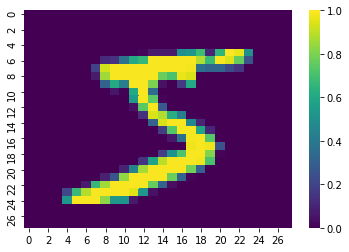

In [6]:
sns.heatmap(x_train[0,:,:,0], cmap="viridis")

#### ML Pipeline

The following are two standard ML models. The first model is a wide RELU model with a small regularization step which ends with a softmax to each of the 10 different categories.

The second model is a convolutional neural net which means it is creating nodes based on the spatial autocorrelation at each pixel. For certain types of images, the structure of an image is better understood by the autocorrelation of the pixels than by the pixels themselves. You can vary the size of the convolution with the `kernel_size` parameter. However, convolutions can easily slow down your pipeline and so a Pooling layer is used to downsample the image to more manageable pieces. As you can see in the figure of the 5 above, there are large sections of the figure which are 0. Pooling may combine those sections to lower the dimensionality of the problem to solve it quicker. At the end, a similar pipeline to the original model is placed.

Once a neural net pipeline is established, `model.compile` defines how TensorFlow solves the neural net. Adam (or adaptive moment estimation) optimizer has some nice properties which tends to make it faster and lighter than other optimizers such as stochastic gradient decent. The loss function, sparse categorical cross-entropy, is standard for large categorical problems. Lastly, you can use any number of metrics to validate your model.

In [7]:
def build_default_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])
    return model

def build_conv_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3),
                               activation ='relu', data_format="channels_last"),
        tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, padding = 'Same',
                               activation ='relu'),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, padding = 'Same',
                               activation ='relu'),        
        tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = "softmax")
])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])
    return model

defaul_model = build_default_model()
conv_model = build_conv_model()

In [8]:
# Print evidence of each epoch ending in readable format
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

If you don't have a GPU, I would recommend turning down the number of epochs so that the model finishes in a reasonable amount of time. As you can see in the plots, the neural nets converge in relatively quickly epochs. The default took me just shy of 7 minutes while the convolutional model took me ~11 minutes. Testing on CPU would increase to time to ~70 minutes and ~110 minutes respectively.

In [9]:
default_history = defaul_model.fit(x_train, y_train, epochs=100,
                                   validation_split=0.25, verbose=0,
                                   validation_data=(x_test, y_test),
                                   callbacks=[PrintDot()])


..................................................
..................................................

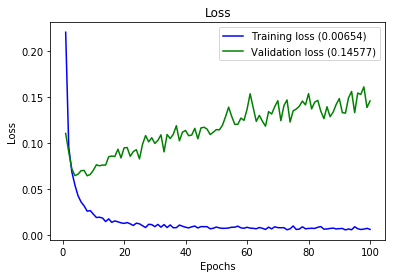

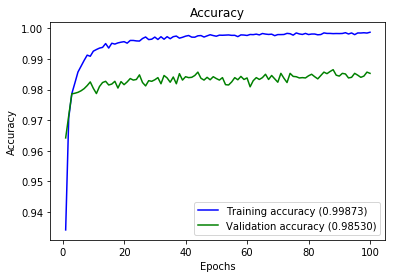

In [10]:
plot_history(default_history)

In [61]:
confusion_matrix(y_true=y_test, y_pred=defaul_model.predict_classes(x_test, verbose=0))

array([[ 974,    0,    1,    0,    1,    0,    1,    1,    1,    1],
       [   0, 1127,    3,    0,    0,    0,    2,    1,    2,    0],
       [   2,    0, 1015,    2,    3,    0,    3,    4,    3,    0],
       [   1,    0,    5,  991,    0,    2,    0,    6,    3,    2],
       [   0,    0,    3,    0,  971,    0,    3,    0,    2,    3],
       [   1,    0,    0,    7,    1,  877,    3,    1,    1,    1],
       [   3,    2,    0,    1,    3,    6,  942,    0,    1,    0],
       [   0,    1,    6,    1,    1,    0,    0, 1013,    2,    4],
       [   4,    0,    4,    2,    2,    1,    1,    4,  953,    3],
       [   0,    2,    0,    2,    5,    3,    0,    4,    3,  990]])

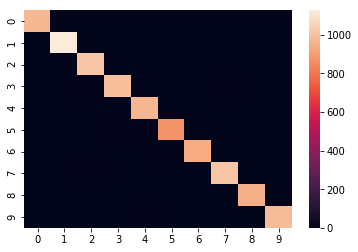

In [62]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=defaul_model.predict_classes(x_test, verbose=0)))

In [11]:
conv_history = conv_model.fit(x_train, y_train, epochs=100,
                              validation_split=0.25, verbose=0,
                              validation_data=(x_test, y_test),
                              callbacks=[PrintDot()])


..................................................
..................................................

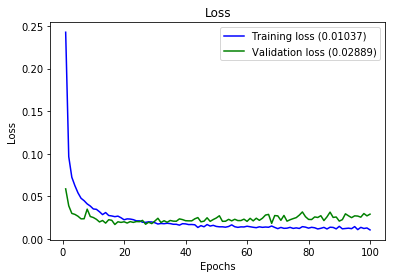

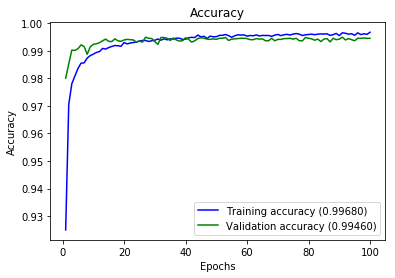

In [12]:
plot_history(conv_history)

In [63]:
confusion_matrix(y_true=y_test, y_pred=conv_model.predict_classes(x_test, verbose=0))

array([[ 979,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       [   0, 1132,    0,    1,    0,    0,    1,    1,    0,    0],
       [   1,    1, 1028,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0,    0, 1007,    0,    1,    0,    0,    2,    0],
       [   0,    0,    0,    0,  976,    0,    0,    0,    0,    6],
       [   0,    0,    0,    6,    0,  885,    1,    0,    0,    0],
       [   3,    1,    0,    0,    1,    0,  951,    0,    2,    0],
       [   0,    3,    4,    0,    0,    0,    0, 1017,    1,    3],
       [   0,    0,    2,    1,    0,    0,    0,    0,  970,    1],
       [   0,    0,    0,    0,    5,    2,    0,    1,    0, 1001]])

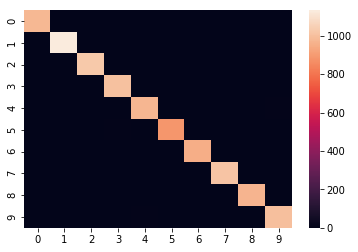

In [60]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=conv_model.predict_classes(x_test, verbose=0)))